In [1]:
import numpy as np
from numpy.random import default_rng
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import preprocessing

# Part 1 - Defining the environment.

In [2]:
class StockTradingEnv:
    """
        Specifying the action and observation componenets that would help the agent to learn and move though the environment
        
    """
    def __init__(self,
               fee=0.1,
               starting_date="2015-01-24",
               max_training_date = '2020-12-31',
               inital_cash_balance = 50000,
               initial_number_shares = 10):
        
        # Defining the parameters specific to the environment
        self.df = pd.read_excel("Quantitative Trading2.xls", sheet_name='SPY (1)')
        self.action_list = ['Buy','Sell','Hold']
        self.feature_list = ['Daily Close Returns ', 'Open','High','Low','Close', 'WR(6)', 'WR(12)', 'RSI(14)']
        #setup
        self.fee = fee #Stock trading commission fee per trade
        self.start_date = starting_date
        self.current_step = 0
        self.eventlog = [] #eventlog to keep track 
        self.max_training_date = max_training_date

        #used to calculate portfoliovalue
        self.initial_number_shares = initial_number_shares
        self.inital_cash_balance = inital_cash_balance
        self.cash_balance = self.inital_cash_balance
        self.number_shares = self.initial_number_shares
        
        #To_review

        self.df = self.df[self.df['Date']>=datetime.strptime(self.start_date, '%Y-%m-%d')].reset_index(drop = True)
        self.training_data = self.df[self.df['Date']<datetime.strptime(self.max_training_date, '%Y-%m-%d')]
        self.start_date = self.df['Date'].min()

        #maybe needed.
        self.initial_value = self.cash_balance + self.number_shares* self.df[self.df['Date']==self.start_date]['Close'].values[0] # define initial stock price
        self.wallet = [self.initial_value]   
        
        #self.training_data,self.observations, self.states, self.transition_matrix, self.reward_matrix = self.qlearning_preprocessing()
        #data preprocessing
        

        

    def reward_function(self,action, step):
        ''' Reward Policy, if :
        - Sell : Next day return *-100 
        - Buy : Next day return *100
        - Hold : if held and movement superior to 4% negative reward : abs(next day return) * 100/2 to lower the penality
        while if movement undertrading fee, positive reward
        '''

        #Check the line below
        if action == 'Buy':
            reward = (self.df.iloc[step + 1]['Daily Close Returns '])*100 
            
        if action == 'Sell':
            reward = (self.df.iloc[step + 1]['Daily Close Returns '])*-100 
        
        if action == 'Hold': 
            if abs(self.df.iloc[step + 1]['Daily Close Returns ']*100) >4:
                reward = abs(self.df.iloc[step + 1]['Daily Close Returns '])*-100/2
            
            elif abs(self.df.iloc[step + 1]['Daily Close Returns '])*100 <self.fee:
                reward = abs(self.df.iloc[step + 1]['Daily Close Returns '])*200
            
            else :
                reward = 0
        
        return reward
        
    def step(self,action):
        """
        Move the step and recalculate portfolio Value 
        """
        
        #Check the line below
        self._state = self.df.iloc[self.current_step]
        current_price = self.df.iloc[self.current_step]['Close']
         
        ## Add condition if buy but enough cash -> hold (bump example) and similarly if sell but no more share -> hold
        if action == 'Buy':
            #transition function
            if current_price > self.cash_balance:
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = 'Not Enough Cash to Buy'
            else : 
                self.number_shares +=1
                self.cash_balance = self.cash_balance -self.fee - current_price
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = ''
            
        if action == 'Sell':
            if self.number_shares ==0 :
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = 'Not Enough Shares to Sell '

            else:
                self.number_shares -=1
                self.cash_balance = self.cash_balance -self.fee + current_price
                self.wallet.append(self.cash_balance + self.number_shares* current_price)
                comment = ''
        
        if action == 'Hold': 
            self.wallet.append(self.cash_balance + self.number_shares* current_price)
            comment = ''
        
        #create pandas or array of array which will include = step, action, state, wallet value, reward.     
        self.eventlog.append([self.current_step, self.number_shares,self.cash_balance,current_price,action,comment])
        self.current_step+=1

        
    def display(self):
        print ('Portfolio contains :' + str(self.number_shares ))
        print ('Initial Portfolio Value was : '+ str(self.initial_value))
        print (self.wallet)
        #to add 
        print ('total reward')

    def reset(self):
        self.current_step = 0
        self.cash_balance = self.inital_cash_balance
        self.number_shares = self.initial_number_shares
        self.eventlog = []
        self.initial_value = self.cash_balance + self.number_shares* self.df[self.df['Date']==self.start_date]['Close'].values[0] # define initial stock price

    def qlearning_preprocessing (self):

        #kmeans
        print('Clustering')
        kmeans = KMeans(n_clusters=7)
        
        standard = preprocessing.scale(self.training_data[self.feature_list])
        standard = pd.DataFrame(standard, columns =self.feature_list)
        
        y = kmeans.fit_predict(standard)
        self.training_data['Cluster'] = y
        centroid = kmeans.cluster_centers_
        
        
        fig, ax = plt.subplots()
        plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 6], s = 100, c = 'blue', label = ['state_0', 'state_1', 'state_2','state_3','state_4','state_5','state_6'])
        for i,txt in enumerate(['state_0', 'state_1', 'state_2','state_3','state_4','state_5','state_6']):
            ax.annotate(txt, (kmeans.cluster_centers_[i, 0]+0.08, kmeans.cluster_centers_[i, 6]-0.08))
        plt.title('State Representation')
        
        ax.set_xlim(xmin=(kmeans.cluster_centers_[:, 0]).min()-0.2, xmax=(kmeans.cluster_centers_[:, 0]).max()+0.2)
        plt.xlabel(self.feature_list[0])
        plt.ylabel(self.feature_list[6])
        plt.show()
        plt.clf() 
        
        print('Calculating historical expected transition matrix')
        self.training_data['next_cluster']=self.training_data['Cluster'].shift(-1)
        self.training_data['Count'] = 1
        transition_matrix = pd.pivot_table(self.training_data, values='Count', index=['Cluster'],columns=['next_cluster'], aggfunc=np.sum)
        transition_matrix = transition_matrix/sum(self.training_data['Count'])
        transition_matrix =transition_matrix.fillna(0)*100

        sns.heatmap(transition_matrix, cmap = 'Blues',annot=True, fmt ='.2f')
        plt.title('State Transition Matrix')
        plt.show()
        plt.clf()

        print('Calculating historical expected return matrix for state-action')        
        matrix_rewards =  np.zeros((7, 3))
        simulated_er = []
        n=0
        
        #In order to descretise the return, we looked at expected return by simulating 1 day sell,1 day buy 1 day hold( do nothing)
        for i in range(len(self.training_data.index)-1) :
            for action in range (3):
                reward = self.reward_function(self.action_list[action],i)
                simulated_er.append([i,self.action_list[action],reward, self.training_data.iloc[i]['Cluster']])

        simulated_er= pd.DataFrame(simulated_er, columns = ['i','Action', 'Reward','State'])
        #to debug : simulated_er.to_csv('histreward.csv')
        reward_matrix = pd.pivot_table(simulated_er, values='Reward', index=['State'],columns=['Action'], aggfunc=np.sum)
        reward_matrix=reward_matrix[ self.action_list]
        sns.heatmap(reward_matrix, cmap = 'Blues',annot=True, fmt ='.2f')
        plt.title('reward_matrix')
        plt.show()
        plt.clf()
        print('End of Preprocessing')
        return self.training_data, transition_matrix, reward_matrix
        

# Part 2 - Q-Learning Agent.


## Setting up the environment

Extracting time period, Defining State, and returning transition Matrix annd state transition function 
Clustering


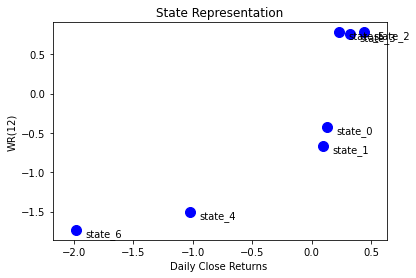

Calculating historical expected transition matrix


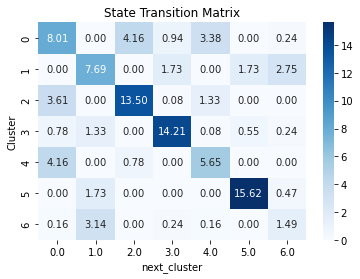

Calculating historical expected return matrix for state-action


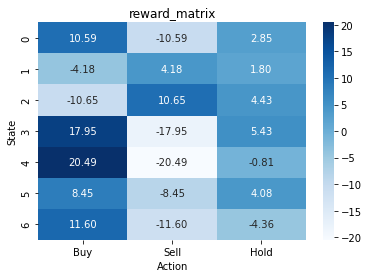

End of Preprocessing


<Figure size 432x288 with 0 Axes>

In [3]:

trading = StockTradingEnv()
print ('Extracting time period, Defining State, and returning transition Matrix annd state transition function ')
trading.training_data, transition_matrix, reward_matrix = trading.qlearning_preprocessing()

## Setting up the Q-Learning Agent

In [38]:
#each episode are training on 1 year of data as we are trying to maximize our return over a year.
def Qlearning_Agent(epsilon,alpha, gamma, reward_matrix, is_eps_decay = False,episoden =100):
    episode_log =[]
    emptyDict = {}
    decay = 0.99
    epsilon_min = 0.1


    Q = np.zeros(reward_matrix.shape)
    
    for episode in range (episoden):
        rewardlist =[]
        cumulative_reward = 0
        trading.reset()

        for i in range(len(trading.training_data.index)-1):   
            #to add code
            possible_action = trading.action_list
            
            
            state = trading.training_data.iloc[trading.current_step]['Cluster']
            q_values = [Q[state,possible_action.index(a)] for a in possible_action]
            best_actions =  np.array(possible_action)[np.where(q_values == np.max(q_values))[0]]
            best_actions_q_values = [Q[state,possible_action.index(x)] for x in best_actions]

            #Policy Epsilon-greedy
            
            
            is_greedy = random.random() > epsilon
        
            if is_greedy :
            # we select greedy action
                a = np.random.choice(best_actions)
            else:
            # we sample a random action
                 a = np.random.choice(possible_action)


            # Environment updating
            r = reward_matrix.iloc[state][a]
            cumulative_reward += r
            rewardlist.append(r)
            s_old = state
            state = trading.training_data.iloc[trading.current_step+1]['Cluster']

            # here, the transition function is stochastic. Next state is dependend of markets conditions evolving .
            q_values = [Q[state,possible_action.index(a)] for a in possible_action]
            q_updated = Q[s_old,possible_action.index(a)] + alpha * ( r + gamma * np.max(q_values) - Q[s_old,possible_action.index(a)])
            Q[s_old,possible_action.index(a)] = q_updated
            trading.step(a) 

        episode_log.append([episode,cumulative_reward])
        if is_eps_decay == True:
            epsilon = epsilon*decay
        if epsilon < epsilon_min:
            epsilon = epsilon_min
        
    episode_log_df = pd.DataFrame(episode_log,columns=['episode','Cumulative Rewards'])
    


    return episode_log_df,Q
    

### Selected Alpha, Beta and policy  

In [43]:
ep_log, Qlearned = Qlearning_Agent(0.1,0.01,0.8, reward_matrix)

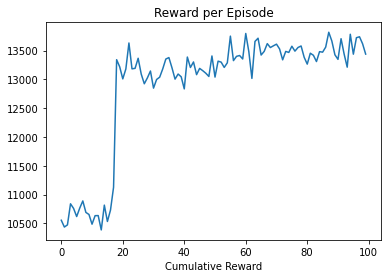

In [44]:
plt.plot(ep_log['Cumulative Rewards'])   
plt.title('Reward per Episode')
plt.xlabel('Episodes')
plt.xlabel('Cumulative Reward')
plt.show()

In [61]:
    
last_episode = pd.DataFrame(trading.eventlog,columns =['episode', 'shares', 'cash','price','action','comment' ])
last_episode['NAV'] = last_episode['cash'] + last_episode['shares']*last_episode['price']
last_episode['Return'] = last_episode['NAV']/trading.inital_cash_balance - 1
last_episode['Price Return'] = last_episode['price']/trading.df[trading.df['Date']==trading.start_date]['Close'].values[0]-1
last_episode['Cash%'] = last_episode['cash'] /last_episode['NAV'] *100
last_episode.head(5)

,episode,shares,cash,price,action,comment,NAV,Return,Price Return,Cash%
0,0,9,50205.349997,205.449997,Sell,,52054.399970,0.041088,0.000000,96.447851
1,1,10,50002.509992,202.740005,Buy,,52029.910042,0.040598,-0.013191,96.103395
2,2,11,49802.269993,200.139999,Buy,,52003.809982,0.040076,-0.025846,95.766579
3,3,12,49600.179988,201.990005,Buy,,52024.060048,0.040481,-0.016841,95.340848
4,4,13,49400.629991,199.449997,Buy,,51993.479952,0.039870,-0.029204,95.013125


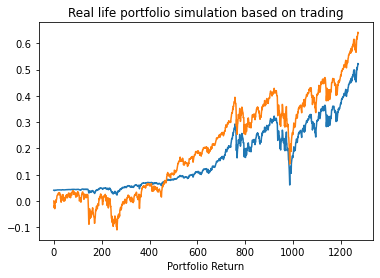

In [62]:
#Real life portfolio simulation based on signal
plt.plot(last_episode['Return'], label = 'Strategy Return')   
plt.plot(last_episode['Price Return'], label = 'ETF Return') 
plt.title('Real life portfolio simulation based on trading')
plt.xlabel('Days cumulated')
plt.xlabel('Portfolio Return')
plt.show()

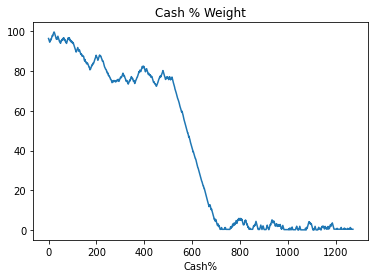

In [60]:
#Real life portfolio simulation based on signal
plt.plot(last_episode['Cash%'])   
plt.title('Cash % Weight')
plt.xlabel('Days cumulated')
plt.xlabel('Cash%')
plt.show()

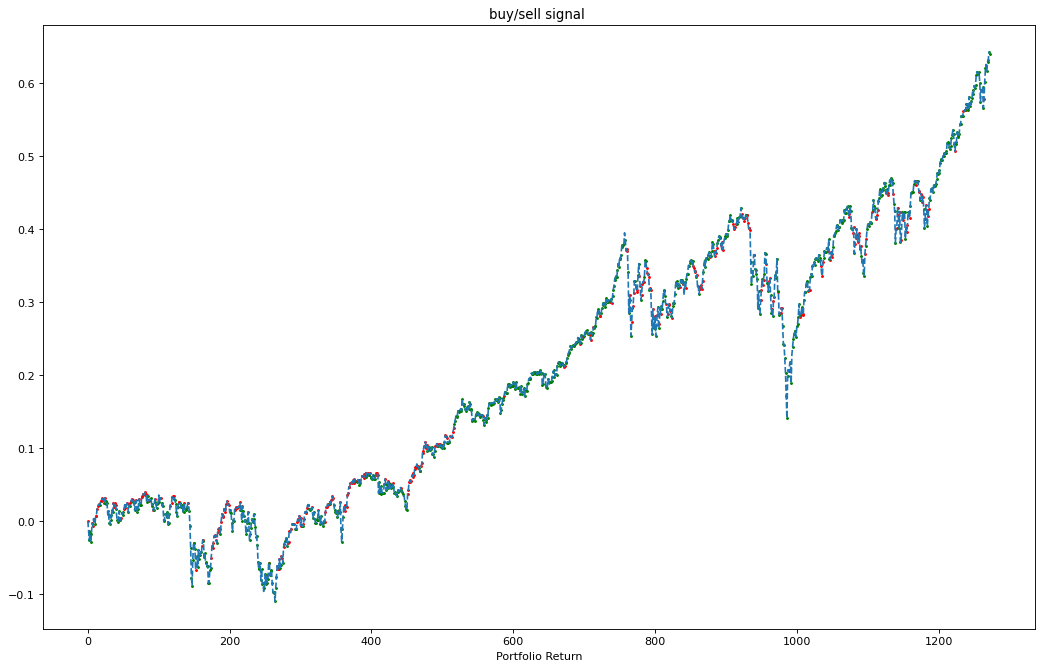

In [82]:
figure(figsize=(16,10), dpi=80)
plt.plot(last_episode['episode'],last_episode['Price Return'], linestyle='dashed', label = 'ETF Return') 

plt.scatter(last_episode[last_episode['action']=='Sell']['episode']
            ,last_episode[last_episode['action']=='Sell']['Price Return']
            ,marker="."
            ,color = 'red'
            , label = 'Sell',s = 10) 

plt.scatter(last_episode[last_episode['action']=='Buy']['episode']
            ,last_episode[last_episode['action']=='Buy']['Price Return']
            ,marker="."
            ,color = 'green'
            , label = 'Buy'
           , s =10) 

plt.title('buy/sell signal ')
plt.xlabel('Days cumulated')
plt.xlabel('Portfolio Return')
plt.show()

### Other combination

In [5]:
alpha_test = [0.01, 0.15, 0.2]
gamma_test = [0.4,0.7,0.9]
epsilon = 0.1

fulllog = None
QLdictionary = {}
for alpha in alpha_test :
    for g in gamma_test : 
        hypcomb ='-a:'+str(round(alpha,2))+' -g:'+str(round(g,1))
        print ('-a:'+str(round(alpha,2))+' -g:'+str(round(g,1)))
        ep_log, Qlearned = Qlearning_Agent(epsilon,alpha,g, reward_matrix)
        ep_log['Hyperparameter'] = hypcomb
        QLdictionary[hypcomb] = Qlearned
        if fulllog is None :
            fulllog =ep_log
        else:
            fulllog =fulllog.append(ep_log)

-a:0.01 -g:0.4
-a:0.01 -g:0.7
-a:0.01 -g:0.9
-a:0.15 -g:0.4
-a:0.15 -g:0.7
-a:0.15 -g:0.9
-a:0.2 -g:0.4
-a:0.2 -g:0.7
-a:0.2 -g:0.9


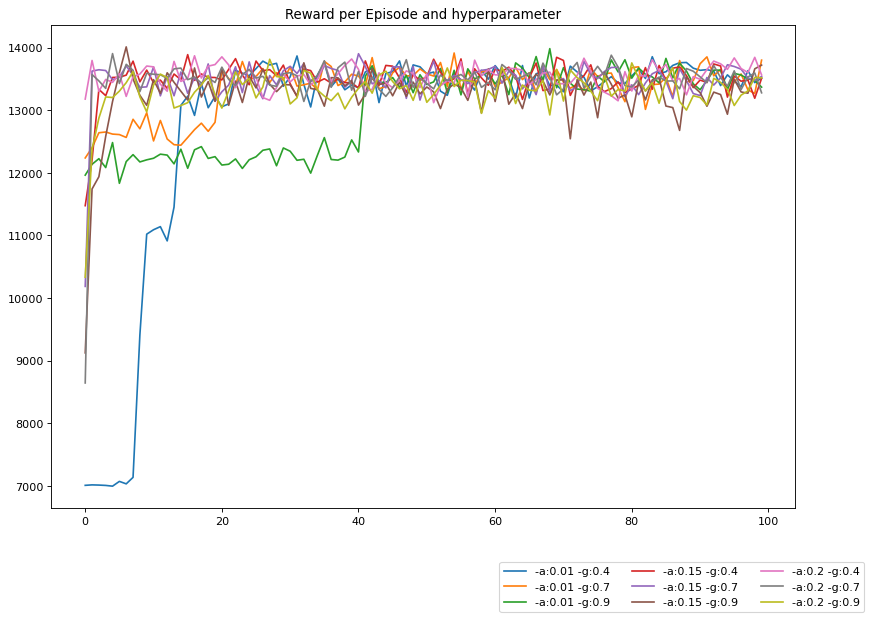

In [6]:
figure(figsize=(12,8), dpi=80)
for h in fulllog['Hyperparameter'].drop_duplicates():
    temp =  fulllog[fulllog['Hyperparameter'] == h]
    plt.plot(temp['Cumulative Rewards'], label = h)   

plt.title('Reward per Episode and hyperparameter')
plt.xlabel('Episodes')
plt.xlabel('Cumulative Reward')
plt.legend(fancybox = True, bbox_to_anchor=(1.1, -0.1), ncol = 3 )
plt.show()

In [7]:
hyperparametergrid = []
for h in fulllog['Hyperparameter'].drop_duplicates():
    temp =  fulllog[fulllog['Hyperparameter'] == h]
    maxreward = temp['Cumulative Rewards'].max()
    minreward = temp['Cumulative Rewards'].min()
    stdreward = temp['Cumulative Rewards'].std()
    meanreward = temp['Cumulative Rewards'].mean()
    print ('For ' +h + ' max,min,std reward : ' + str(round(maxreward,2)) +', '+str(round(minreward,2))+', '
           +str(round(stdreward,2))+', '+str(round(meanreward,2)))

For -a:0.01 -g:0.4 max,min,std reward : 13867.75, 6994.93, 1845.22, 12821.49
For -a:0.01 -g:0.7 max,min,std reward : 13915.17, 12238.25, 398.42, 13343.74
For -a:0.01 -g:0.9 max,min,std reward : 13984.6, 11833.2, 659.44, 13001.18
For -a:0.15 -g:0.4 max,min,std reward : 13888.66, 11475.95, 292.65, 13489.37
For -a:0.15 -g:0.7 max,min,std reward : 13903.51, 10186.32, 373.52, 13475.98
For -a:0.15 -g:0.9 max,min,std reward : 14012.58, 9123.96, 526.78, 13257.69
For -a:0.2 -g:0.4 max,min,std reward : 13870.5, 13121.0, 179.55, 13536.49
For -a:0.2 -g:0.7 max,min,std reward : 13905.45, 8643.47, 509.36, 13466.48
For -a:0.2 -g:0.9 max,min,std reward : 13814.42, 10332.82, 373.68, 13305.18


In [33]:
alpha_test = [0.01, 0.15, 0.2]
gamma_test = [0.4,0.7,0.9]
starting_epsilon = 0.9


fulllogd = None
QLdictionaryd = {}
for alpha in alpha_test :
    for g in gamma_test : 
            hypcomb ='-a:'+str(round(alpha,2))+' -g:'+str(round(g,1))
            print ('-a:'+str(round(alpha,2))+' -g:'+str(round(g,1)))
            ep_log, Qlearned = Qlearning_Agent(starting_epsilon,alpha,g, reward_matrix, is_eps_decay = True, episoden = 400)
            ep_log['Hyperparameter'] = hypcomb
            QLdictionaryd[hypcomb] = Qlearned
            if fulllogd is None :
                fulllogd =ep_log
            else:
                fulllogd =fulllogd.append(ep_log)

-a:0.01 -g:0.4
-a:0.01 -g:0.7
-a:0.01 -g:0.9
-a:0.15 -g:0.4
-a:0.15 -g:0.7
-a:0.15 -g:0.9
-a:0.2 -g:0.4
-a:0.2 -g:0.7
-a:0.2 -g:0.9


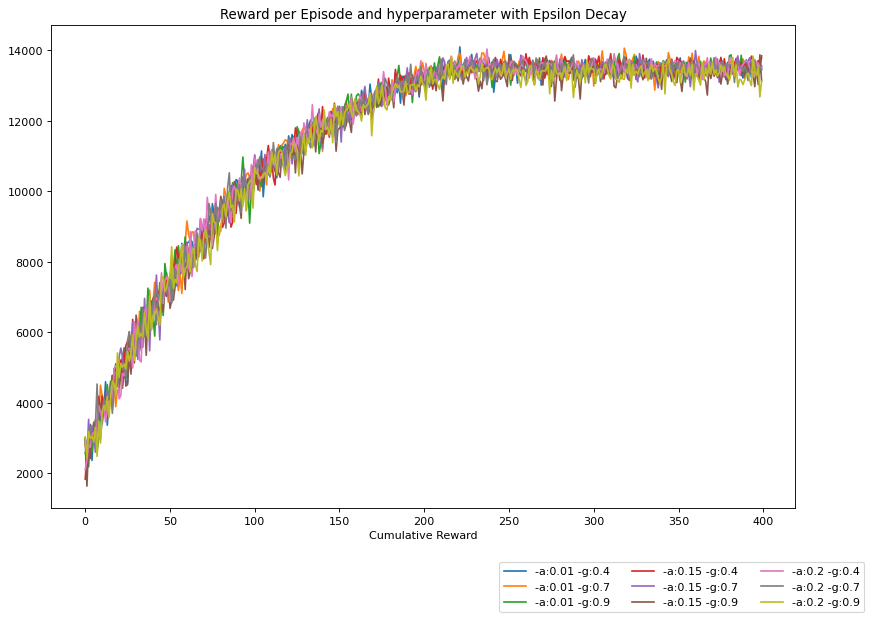

In [34]:
figure(figsize=(12,8), dpi=80)
for h in fulllogd['Hyperparameter'].drop_duplicates():
    temp =  fulllogd[fulllogd['Hyperparameter'] == h]
    plt.plot(temp['Cumulative Rewards'], label = h)   

plt.title('Reward per Episode and hyperparameter with Epsilon Decay')
plt.xlabel('Episodes')
plt.xlabel('Cumulative Reward')
plt.legend(fancybox = True, bbox_to_anchor=(1.1, -0.1), ncol = 3 )
plt.show()

In [35]:
for h in fulllogd['Hyperparameter'].drop_duplicates():
    temp =  fulllogd[fulllogd['Hyperparameter'] == h]
    maxreward = temp['Cumulative Rewards'].max()
    minreward = temp['Cumulative Rewards'].min()
    stdreward = temp['Cumulative Rewards'].std()
    meanreward = temp['Cumulative Rewards'].mean()
    print ('For ' +h + ' max,min,std reward : ' + str(round(maxreward,2)) +', '+str(round(minreward,2))+', '
           +str(round(stdreward,2))+', '+str(round(meanreward,2)))

For -a:0.01 -g:0.4 max,min,std reward : 14095.11, 2367.69, 2913.97, 11527.4
For -a:0.01 -g:0.7 max,min,std reward : 14059.42, 2362.89, 2910.2, 11566.36
For -a:0.01 -g:0.9 max,min,std reward : 13904.62, 2186.37, 2910.79, 11521.41
For -a:0.15 -g:0.4 max,min,std reward : 13901.55, 1837.71, 2891.83, 11543.85
For -a:0.15 -g:0.7 max,min,std reward : 13991.14, 2429.46, 2891.02, 11512.42
For -a:0.15 -g:0.9 max,min,std reward : 13881.99, 1636.86, 2889.41, 11368.69
For -a:0.2 -g:0.4 max,min,std reward : 14034.55, 2103.49, 2928.78, 11538.98
For -a:0.2 -g:0.7 max,min,std reward : 13870.39, 2536.28, 2911.06, 11490.7
For -a:0.2 -g:0.9 max,min,std reward : 13835.43, 2434.76, 2883.79, 11378.11
